## <center>SAP Code Test: Fake News Dectection</center>
<center>Author: Yu Zhe (NUS MSBA)</center>

In [13]:
import re
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
import lightgbm as lgb
from lightgbm import LGBMClassifier
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yuzhe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Part 1:  Data Import and Explorative Analysis (EDA)

In [2]:
df_fake=pd.read_csv('Fake.csv')
df_true=pd.read_csv('True.csv')

In [3]:
df_true.head(2)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"


In [4]:
df_fake.head(2)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"


In [5]:
# Assign label=1 to the true data and label=0 to fake data
df_true['label']=1
df_fake['label']=0

In [6]:
# Concate two dataframes into one
df=pd.concat([df_true,df_fake], axis=0, ignore_index=True)
print(df.shape)

(44898, 5)


In [7]:
df.sample(5)

,title,text,subject,date,label
7637,Kerry says has not been contacted by FBI over ...,"AHERLOW, Ireland (Reuters) - U.S. Secretary of...",politicsNews,"October 30, 2016",1
11526,"Russia says 48,000 of its troops took part in ...","MOSCOW (Reuters) - A total of 48,000 of Russia...",worldnews,"December 22, 2017",1
15976,South Korea's Moon says cannot recognize North...,SEOUL/BEIJING (Reuters) - South Korea will nev...,worldnews,"November 1, 2017",1
39800,SMUG CNN ANCHORS Say They Won’t Release Identi...,The hosts of New Day dug a deeper hole for C...,left-news,"Jul 5, 2017",0
10238,White House says has shared lists of political...,HAVANA (Reuters) - Cuba has political prisoner...,politicsNews,"March 21, 2016",1


In [8]:
# check missing data
df.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

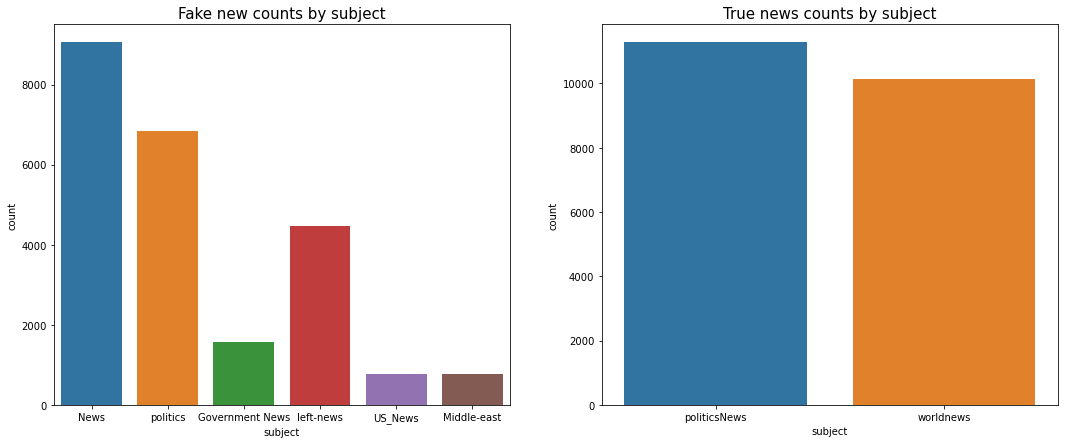

In [9]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(18,7))
ax1=sns.countplot(x='subject', data=df[df.label==0],ax=ax1)
ax1.set_title('Fake new counts by subject',fontsize=15)
ax2=sns.countplot(x='subject', data=df[df.label==1],ax=ax2)
ax2.set_title('True news counts by subject',fontsize=15)
plt.show()

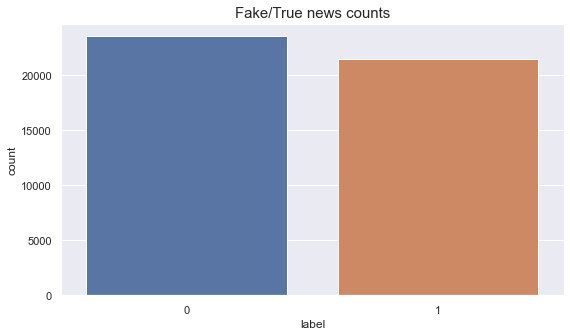

In [12]:
sns.set(rc={'figure.figsize':(9,5)})
ax=sns.countplot(x='label', data=df)
ax.set_title('Fake/True news counts',fontsize=15)

plt.show()

#### Observations and Insights:

1. Counts of real news and false news are close, the dataset is balanced.
2. The real news and false news are naturally distingushed by their subjects. In this analysis, I discard this column to have more real-world simulation.
3. Date column is not used as it is not relevant to our problem.


### Part 2: Data Processing

In [21]:
_CONTRACTION_MAP= {"she'll": 'she will', "shouldn't've": 'should not have', "she'll've": 'she will have', "don't": 'do not', "should've": 'should have', "won't": 'will not', "who'll've": 'who will have', "he's": 'he is', "when's": 'when is', "we've": 'we have', "he'd": 'he would', "ma'am": 'madam', "y'all're": 'you all are', "he'd've": 'he would have', "how'd'y": 'how do you', "shan't've": 'shall not have', "haven't": 'have not', "who's": 'who is', "they'd": 'they would', "oughtn't": 'ought not', "I'd": 'I would', "you've": 'you have', "i'm": 'i am', "she'd've": 'she would have', "we'll": 'we will', "mayn't": 'may not', "they've": 'they have', "mustn't've": 'must not have', "could've": 'could have', "what've": 'what have', "mustn't": 'must not', "isn't": 'is not', "that'd've": 'that would have', "i'll": 'i will', "why's": 'why is', "you'd": 'you would', "couldn't've": 'could not have', "they'll've": 'they will have', "we'd": 'we would', "y'all'd": 'you all would', "he'll've": 'he he will have', "shan't": 'shall not', "y'all'd've": 'you all would have', "there'd": 'there would', "needn't": 'need not', "where'd": 'where did', "hadn't've": 'had not have', "wouldn't've": 'would not have', "there's": 'there is', "shouldn't": 'should not', "they'll": 'they will', "needn't've": 'need not have', "mightn't": 'might not', "you're": 'you are', "so've": 'so have', "what'll": 'what will', "mightn't've": 'might not have', "hadn't": 'had not', "aren't": 'are not', "where's": 'where is', "i'll've": 'i will have', "wouldn't": 'would not', "i'd": 'i would', "weren't": 'were not', "would've": 'would have', "i'm": 'i am', "it'll": 'it will', "we'd've": 'we would have', "can't": 'cannot', "y'all": 'you all', "couldn't": 'could not', "how'll": 'how will', "doesn't": 'does not', "when've": 'when have', "how's": 'how is', "i've": 'i have', "it's": 'it is', "y'all've": 'you all have', "how'd": 'how did', "we're": 'we are', "i'd've": 'i would have', "it'd": 'it would', "what're": 'what are', "i've": 'i have', "oughtn't've": 'ought not have', "what's": 'what is', "ain't": 'is not', "who'll": 'who will', "i'd've": 'i would have', "must've": 'must have', "i'll": 'i will', "they're": 'they are', "you'd've": 'you would have', "wasn't": 'was not', "it'll've": 'it will have', "hasn't": 'has not', "won't've": 'will not have', "so's": 'so as', "you'll've": 'you will have', "there'd've": 'there would have', "i'll've": 'i will have', "didn't": 'did not', "where've": 'where have', "they'd've": 'they would have', "why've": 'why have', "it'd've": 'it would have', "who've": 'who have', "sha'n't": 'shall not', "to've": 'to have', "o'clock": 'of the clock', "let's": 'let us', "what'll've": 'what will have', "'cause": 'because', "might've": 'might have', "he'll": 'he will', "that'd": 'that would', "we'll've": 'we will have', "she'd": 'she would', "can't've": 'cannot have', "you'll": 'you will', "will've": 'will have', "she's": 'she is', "that's": 'that is'}

english_stopwords = stopwords.words('english')
noise_words = ['http', 'https', 'amp', 'quot']  # to be added if necessary
_STOPWORDS = english_stopwords + noise_words

random_seed = 2021

def text_process(text):
    pattern = re.compile("({})".format("|".join(_CONTRACTION_MAP.keys())),flags = re.DOTALL| re.IGNORECASE)
    
    def replace_text(t):
        txt = t.group(0)
        if txt.lower() in _CONTRACTION_MAP.keys():
            return _CONTRACTION_MAP[txt.lower()]
    
    # Expand contraction
    text = pattern.sub(replace_text,text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove punctuations
    text = re.sub(r'[^\s\w]', '', text).lower().strip()
    # Remove stopwords
    words = nltk.word_tokenize(text)
    stopwords_removed= [w for w in words if w not in _STOPWORDS]
    
    return " ".join(stopwords_removed)

In [22]:
%%timeit
df['title']=df['title'].apply(text_process)
df['text']=df['text'].apply(text_process)

4min 34s ± 7.87 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
X_train, X_test, y_train, y_test = train_test_split(df[['title','text']], df.label, test_size=0.15, stratify=df.label, random_state=random_seed)

print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')      
print(f'X_test shape {X_test.shape}, y_test shape {y_test.shape}') 

X_train shape: (38163, 2), y_train shape: (38163,)
X_test shape (6735, 2), y_test shape (6735,)


In [74]:
def train_classifier(classifier, X_train, y_train, X_test, y_test):
    name = classifier.__class__.__name__
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"The accuracy score of the classifier {name} is {accuracy};\nthe F1 score of the classifier {name} is {f1}")

In [253]:
# Process texts as count vectors for base models
# Filter out the most frequent 20% tokens and the least frequent 10% tokens.
count_vect = CountVectorizer(max_df=0.8, min_df=0.1)
count_vect.fit(X_train.text)

X_train_cv = count_vect.transform(X_train.text)
X_test_cv = count_vect.transform(X_test.text)

In [252]:
# TFIDF Vectorizer
# Filter out the most frequent 20% tokens and the least frequent 10% tokens.
tfidf_vect = TfidfVectorizer(max_df=0.8, min_df=0.1)
tfidf_vect.fit(X_train.text)

X_train_tv=tfidf_vect.transform(X_train.text)
X_test_tv = tfidf_vect.transform(X_test.text)

### Part 3: Logistic Regression Model

In [254]:
logreg = LogisticRegression(solver='lbfgs', random_state=random_seed, max_iter=500, n_jobs=-1)

train_classifier(logreg, X_train_cv, y_train, X_test_cv, y_test)

The accuracy score of the classifier LogisticRegression is 0.9921306607275426;
the F1 score of the classifier LogisticRegression is 0.9917714640583761


In [255]:
train_classifier(logreg, X_train_tv, y_train, X_test_tv, y_test)

The accuracy score of the classifier LogisticRegression is 0.9848552338530067;
the F1 score of the classifier LogisticRegression is 0.9841467205470935


### Part 4: LGBM Model

In [256]:
lgbm = LGBMClassifier(n_jobs=-1, random_state=random_seed)

train_classifier(lgbm, X_train_tv.toarray(), y_train, X_test_tv.toarray(), y_test)

The accuracy score of the classifier LGBMClassifier is 0.9964365256124722;
the F1 score of the classifier LGBMClassifier is 0.996268656716418


In [257]:
train_classifier(lgbm, X_train_cv.toarray(), y_train, X_test_cv.toarray(), y_test)

The accuracy score of the classifier LGBMClassifier is 0.9965850037119525;
the F1 score of the classifier LGBMClassifier is 0.996423573316747


###  Observations and Insights:
1. Count Vectorizer generally perform better than TFIDF vectorizer in this task.
2. To reduce the corpus size in the training, only the top 1000 features are taken for training, it shows the scores are slightly lower than full features, but saves lots of computing time.

### Part 5: Deep Learning Model

In [113]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Input, Sequential, Model
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

In [243]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 5000
# Max number of words in each news.
MAX_SEQUENCE_LENGTH = 250
# Fixed embedding dimension.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X_train.text)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 183922 unique tokens.


In [245]:
train_sequences = tokenizer.texts_to_sequences(X_train.text)
train_X = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

print(f"The shape of data tensor: {train_X.shape}")
print(f"The shape of label tensor: {y_train.shape}")

The shape of data tensor: (38163, 250)
The shape of label tensor: (38163,)


In [248]:
test_sequences = tokenizer.texts_to_sequences(X_test.text)
test_X = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

print(f"The shape of data tensor: {test_X.shape}")
print(f"The shape of label tensor: {y_test.shape}")

The shape of data tensor: (6735, 250)
The shape of label tensor: (6735,)


In [246]:
# Build a bidrectional LSTM model with dropout.
input_text = Input(shape=[MAX_SEQUENCE_LENGTH,], dtype='int32')
embedding_layer = Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH)(input_text)
text_embed = SpatialDropout1D(0.2)(embedding_layer)
hidden = Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2))(text_embed)
dense = Dense(256, activation='relu')(hidden)
output = Dense(1, activation='sigmoid')(dense)
model = Model([input_text], [output])

In [247]:
epochs = 5
batch_size = 64
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(train_X, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_split=0.2,
                    callbacks=[EarlyStopping(monitor='val_loss', 
                    patience=3, min_delta=0.0001)])

Epoch 1/5
478/478 [==============================] - 1296s 3s/step - loss: 0.0400 - accuracy: 0.9854 - val_loss: 0.0079 - val_accuracy: 0.9986
Epoch 2/5
478/478 [==============================] - 1298s 3s/step - loss: 0.0030 - accuracy: 0.9993 - val_loss: 0.0062 - val_accuracy: 0.9988
Epoch 3/5
478/478 [==============================] - 1297s 3s/step - loss: 0.0010 - accuracy: 0.9998 - val_loss: 0.0064 - val_accuracy: 0.9991
Epoch 4/5
478/478 [==============================] - 1310s 3s/step - loss: 0.0017 - accuracy: 0.9996 - val_loss: 0.0089 - val_accuracy: 0.9980
Epoch 5/5
478/478 [==============================] - 1306s 3s/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 0.0109 - val_accuracy: 0.9976


In [251]:
_, lstm_accuracy = model.evaluate(test_X, y_test, batch_size=batch_size)
lstm_prob = model.predict(test_X)
lstm_pred=[0 if x<0.5 else 1 for x in list(lstm_prob.reshape(-1))]
lstm_f1 = f1_score(y_test, lstm_pred)

print(f"The accuracy score of the classifier BiLSTM is {lstm_accuracy};\nthe F1 score of the classifier BiLSTM is {lstm_f1}")

106/106 [==============================] - 11s 108ms/step - loss: 0.0073 - accuracy: 0.9984
The accuracy score of the classifier BiLSTM is 0.9983667135238647;
the F1 score of the classifier BiLSTM is 0.9982863374357376


### Part 6: Summary

$$A: Text Precessing$$
    In this dataset, both title and text can be used as training input for classification, here I choose text column as input, while title column as training features can also predict reasonably well.
    The texts are pre-processed before any further vectorization, below steps are performed:
    <ul>
    <li>remove built-in and customised stopwords</li>
    <li>remove punctuations</li>
    <li>remove numbers</li>
    <li>expand contractions</li>
    <li>tokenize</li>
    </ul>
    
$$B: Token Vectorizer$$
    In Logistic Regression and LGBM, texts are first vectorized with either count vectorizer or TFIDF vectorizer, in this particular case, count vectorizer appears to be better. To reduce the corpus size, the most frequent words that appear in more than 80% of documents and the least frequent words that appear in less than 10% of the documents are ignored. By ignoring the less contributing words, the computing time is optimized.    
    In deep learning, texts are vectorized with word embeddings.

$$C: Model Insights:$$

In this study, 3 binary classification models are built to detect the fake news from the true news. The 3 different types of models are:
1. Logistic Regression Model

    Logistic regression model as a basic classfication algorithm noramlly behave quite well in classic binary classifcation problems. 
    
    
2. Light gradient boosting Model (LGBM)

    LGBM as a light version gradient boosting model, allows for comprehensive parameters tunning at reasonable computing costs, it normally perform well in binary classification. In this particular case, model tunning is not performed but the predicted results are good.
    
    
3. Deep Learning Bidrectional LSTM Model

    As the state-of-art technology, deep learning models are robust in solving NLP problem. In this exercise, I first embedded the words tokens into embedding vectors, and feed into a bidirectional LSTM model.The model had not gone through further tunning and layer adding, due to the limitation of computing resources, it only takes maximum 5000 words with sequence of words truncated at 250, though its performance is already the best among 3 models, it can be further improved in more complicated problems.
    
    Among the three models, logistic regression is always good to be a benchmark base model which can normally produce a good binary classification at low cost. LGBM provides tunning flexiblity that can normally stretch the model performance to its best among machine learning algorithms at a fast speed. In these models, predictions are done based on word counts or frequency.  However, in particular to NLP tasks, the deep learning model is normally a superior choice, as it can consider the semantic and syntactic effects and the textual similarity when dealing with the word tokens. It is the state-of-art technology that is robust in solving NLP problems.
